# Nonreciprocal dispersion of synthetic antiferromagnet
This example shows how to calculate dispersion of synthetic antiferromagnet. It also uses method `SWT.GetPhisSAFM()` to find the equilibribrium state of the coupled magnetization vectors and method `SWT.GetDispersionSAFNumeric()` which numerically calculates eigenvalues of the system matrix which is constructed from the provided input values. The individual elements of the matrix represent magnetic interactions within the system. The eigenvalues then represent angular frequencies of the spin wave modes. *(The eigenvectors can provide spin-wave amplitudes but this is not implemented into SWT yet.)* 
This calculation is described in detail in the supplementary material of the work \[[Gallardo et al., Phys. Rev. Applied 12, 034012 (2019)](https://doi.org/10.1103/PhysRevApplied.12.034012)\]. It was also used in the work \[[Wojewoda et al., arXiv:2311.10044](https://arxiv.org/abs/2311.10044)\].

In [1]:
# necessary imports
import sys; sys.path.append('../') #to be able to locate and import SpinWaveToolkit.py
import SpinWaveToolkit as SWT
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
kxi = np.linspace(-100e6, 100e6, 200) #define numpy array with k-vectors we want to calculate
lxi = 2*np.pi/(kxi*1e-6) #for convenience prepare also numpy array with wavelengths

In [3]:
# Define some variables here to have them easilly accessible on one place

# Material
Ms = 1329e3 # Saturation magnetization in A/m
Aex = 15e-12 # Exchange stiffness in J/m
alpha = 40e-4 # Damping constant in -
gamma = 30*2*np.pi*1e9 # Gyromagnetic ratio in rad/s

# Geometry
d = 10e-9 # thickness of the first layer in m 
s=0.6e-9 # thickness of the spacer in m
d2=10e-9 # thickness of the second layer in m

# RKKY coupling
Jbl = -0.67e-3 # Bilinear RKKY coupling strength
Jbq = -0.28e-3 # Biquadratic RKKX coupling strength

# Anisotropy
Ku = 1.5e3 # in plane anisotropy in the first SAF layer
Ku2 = Ku # the second layer has the same anisotropy as the first
phiAnis1 = 90 # in plane angle of the anisotropy direction in the first SAF layer, here in degrees 
phiAnis2 = -phiAnis1 # in plane angle of the anisotropy direction in the second SAF layer, here in degrees
phiInit1= -45 # initial angle of magnetization in the first layer from which we start to look for the equilibrium state
phiInit2= 45 # initial angle of magnetization in the second layer from which we start to look for the equilibrium state

# External field
Bext = 100e-3 # applied magnetic field in T
phiBext = 0 # in plane angle of the applied magnetic field, here in degrees

In [4]:
# Define material class
CFB = SWT.Material(Ms = Ms, Aex = Aex, alpha = alpha, gamma=gamma)
# Plug all necessary variables into the SWT.Dispersion characteristic class 
SAF = SWT.DispersionCharacteristic(kxi = kxi, theta = np.deg2rad(90), phi = np.deg2rad(phiBext), boundaryCond = 1, Bext = Bext, material = CFB, 
                                   Ku = Ku, Ku2 = Ku2, Jbl = Jbl, Jbq = Jbq, d = d, s = s, d2 = d2, phiAnis1=np.deg2rad(phiAnis1), 
                                   phiAnis2=np.deg2rad(phiAnis2), phiInit1=np.deg2rad(phiInit1), phiInit2=np.deg2rad(phiInit2))

## Find equilibrium state of the two coupled magnetization vectors
SpinWaveToolkit looks for the equilibrium state (minimizes the total energy) of the two coupled magnetizations vectors. The angle of these vectors is then used to calculate the dispersion. Sometimes the minimization procedure can give strange results and it is better to check if the magnetization angles are as expected.

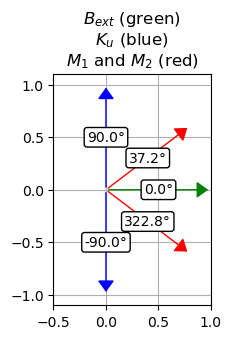

In [5]:
# Now we can have a look at the equilibrium canted state. First we get the angles of the magnetization in both layers
phi1, phi2 = SAF.GetPhisSAFM()

#And then we can plot them to see if the minimization angle with arrow
def plot_angle_arrow(angle, color, radius=1):
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))
    ax = plt.gca()
    ax.plot([0, x], [0, y], linewidth=0)  # Plot line from origin to point
    ax.annotate('', xy=(x, y), xytext=(0, 0),
                arrowprops=dict(arrowstyle="-|>,head_length=0.7,head_width=0.5", color=color))  # Plot arrow
    ax.text(0.5*x, 0.5*y, "{:.1f}°".format(angle), ha='center', va='center', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))  # Angle label rounded to one decimal place

# Make plot with arrows representing all important angles
plt.figure(figsize=(3, 3))
plt.title('$B_{ext}$ (green) \n$K_u$ (blue) \n$M_1$ and $M_2$ (red)')
plt.gca().set_aspect('equal', adjustable='box') #make sure aspect ratio is 1:1 so angles are not distorted
plt.xlim(-0.5, 1)
plt.grid(True)
plot_angle_arrow(phiAnis1, 'blue')  # Anisotropy
plot_angle_arrow(phiAnis2, 'blue')
plot_angle_arrow(np.rad2deg(phi1), 'red')
plot_angle_arrow(np.rad2deg(phi2), 'red')
plot_angle_arrow(phiBext, 'green') # External field
plt.show()

## Get dispersion relation and plot it
If the equilibribrium magnetization is OK, we can now call `SWT.GetDispersionSAFNumeric()` method to get the acoustic and optic mode of the dispersion. We can also plot the dispersion together with description summarizing parameters used for the calculation.

In [6]:
f = SAF.GetDispersionSAFMNumeric()/(1e9*2*np.pi) 
SAF1 = f[2,:] #acoustic mode
SAF2 = f[3,:] #optic mode

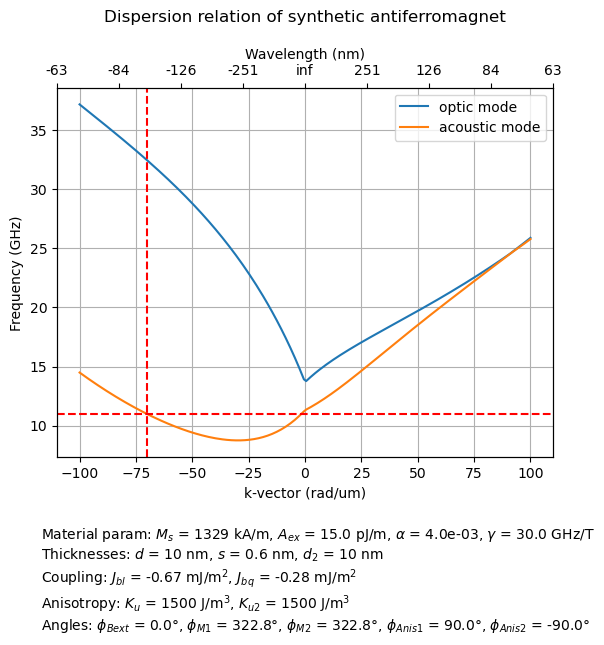

In [12]:
from matplotlib.ticker import FuncFormatter # this is needed to recalculate second axis into wavelengths
warnings.filterwarnings('ignore') #suppress division by zero warning

plt.figure()
plt.grid(True)

# Plot dispersions with legends
plt.plot(kxi*1e-6, SAF2, label = 'optic mode');
plt.plot(kxi*1e-6, SAF1, label = 'acoustic mode');
plt.legend()

# Add tithe and axis labels
plt.title('Dispersion relation of synthetic antiferromagnet\n')
plt.xlabel('k-vector (rad/um)')
plt.ylabel('Frequency (GHz)')

# Add some marker lines
plt.axhline(11, color='red', linestyle='--')
plt.axvline(-70, color='red', linestyle='--')

# Add second x-axis with wavelength in nanometers
def custom_formatter(x, pos):
    return "{:.0f}".format((2*np.pi/(x))*1000)
plt2 = plt.twiny()
plt2.spines['top'].set_visible(True)
plt2.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.xlabel('Wavelength (nm)')

# Need to reset the axis limits
plt.xlim(min(kxi*1e-6), max(kxi*1e-6))

# Add info text below the plot so we always know what is plotted
info_text = (
    'Material param: $M_s$ = %.1d kA/m, $A_{ex}$ = %.1f pJ/m, $\\alpha$ = %.1e, $\\gamma$ = %.1f GHz/T \n'
    'Thicknesses: $d$ = %.1d nm, $s$ = %.1f nm, $d_2$ = %.1d nm\n'
    'Coupling: $J_{bl}$ = %.2f mJ/m$^2$, $J_{bq}$ = %.2f mJ/m$^2$\n'
    'Anisotropy: $K_u$ = %.1d J/m$^3$, $K_{u2}$ = %.1d J/m$^3$\n'
    'Angles: $\phi_{Bext}$ = %.1f°, $\phi_{M1}$ = %.1f°, $\phi_{M2}$ = %.1f°, $\phi_{Anis1}$ = %.1f°, $\phi_{Anis2}$ = %.1f°'
) % (Ms/1e3, Aex*1e12, alpha, gamma/2/np.pi/1e9, d*1e9, s*1e9, d2*1e9, Jbl*1e3, Jbq*1e3, Ku, Ku2, phiBext, np.rad2deg(phi1), np.rad2deg(phi1), phiAnis1, phiAnis2)
plt.figtext(0.1, -0.25, info_text, ha='left', fontsize=10)

# show the plot
plt.show()